# Azure Machine Learning Service - Execution Environments & Compute
In this fifth part from the same Azure Machine Learning Service (**AML**) series I will do a experiment to :
* Describe AML **Environment** provisioning options. The environment definition and configuration allow us to deploy model consistently across various compute platform thus reducing the overhead of maintaining separately.
* Describe various types of AML **Compute Targets** options and ways to use and manage them in a ML project. 
* The Compute Targets allows us to provision an execution environment according to the experiments training, validation and deployment needs.

## Recap: Azure Machine Learning Service
#### Expand the section below to learn from the previous Notebooks and quick recap of the concepts covered so far.

<u>**IMPORTANT NOTE**</u>

>Please proceed with this example **iff** you are familier with foundation of Microsoft Azure public cloud. In this notebook, the basics of Microsoft Azure and its development methodology is not covered. As it will be beyond the scope of this notebook.

* [PART 1: Azure Machine Learning service - Introduction](https://www.kaggle.com/pankaj1234/azure-machine-learning-introduction): in the first notebook I have already discussed about the nitty-gritty of Azure ML service.
    * Creating an instance of Azure ML service
    * Downloading libraries/dependencies (in Kaggle environment)
    * Various methods to connect to Azure ML service workspace: using config file and using get() method.
    * Simple ML experiment - for data exploration. Capture the details from the experiment, logging and preserving the run details from the experiment.
    * Overview of Azure ML Service Dashboard. Experiment Dashboard.
    
* [PART 2: Azure Machine Learning service - Introduction II](https://www.kaggle.com/pankaj1234/azure-machine-learning-introduction-ii): I did deep-dive into the introduction and covered some more topics:
    * Create and run the experiment using <u>Custom Script</u> file. Implementing simple Logistic Regression model on IRIS dataset.
    * RunConfiguration and ScriptRunConfiguration, these classes were used to define the runtime environment for the custom script.
    * Output the model and run details to the external folder for future referencing.

* [PART 3: Azure Machine Learning service - Model Training](https://www.kaggle.com/pankaj1234/azure-machine-learning-model-training): I discussed about: 
    * Create and run the experiment using <u>Parameterized Custom Script</u> file. Passing a parameter value uning argparse allowed me to run the experiment using different settings.
    * **ESTIMATOR** object was used to encapsulate both RunConfiguration and ScriptRunConfiguration. Also dicussed about Generic estimator and frame-work specific estimators such as SKLearn, TensorFlow, etc... 
    * Register the model, model versions and its metadata. It is the foundation of any model deployment over various compute with its dependencies (this i will discuss much later). 
* [PART 4: Azure Machine Learning - Working with Data](https://www.kaggle.com/pankaj1234/azure-machine-learning-working-with-data): I discussed about: 
    * Describe cloud **DATASTORES** and ways to use and manage them in a ML project. 
    * Enable remote **DataSets** to train any registered models. they are a versioned reference to a specific set of data that we want to use in an experiment

## Import AML libraries & workspace
The following (hidden) section will load required AML libraries and workspace required to run the experiment.

In [ ]:
# import the Azure ML libs.
!pip install azureml
!pip install azureml.core
!pip install azureml.widgets
!pip install azureml.train
!pip install azureml.dataprep

import azureml.core
import azureml.widgets 
print("Ready to use Azure ML", azureml.core.VERSION)
from azureml.core import Workspace

In [ ]:
## In this segment you should replace the 3-parameters values according to the workspace available in the subscription
## ths experiment will not work beyond this point if these values are not appropriatly inserted.
## HENCE, THE Notebook Execution will terminate

## Example - 
    ## ws = Workspace.get(name="<<MLSERVICENAME>>", subscription_id='<<GUID - ML Service ID>>', resource_group='<<Hosting Azure Resource Group>>')

# Pulling values from Kaggle Secrets
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
MLServiceName = user_secrets.get_secret("MLServiceName")
az_resource_grp  = user_secrets.get_secret("az_resource_grp")
sub_id = user_secrets.get_secret("sub_id")
## Instanciating the Workspace object.
ws = Workspace.get(name=MLServiceName, subscription_id=sub_id, resource_group=az_resource_grp)
print(ws.name, "loaded")

## Recap: Prepare Data

In [ ]:
from azureml.core import Dataset
default_ds = ws.get_default_datastore()
if 'flower tab ds' not in ws.datasets:
    default_ds.upload_files(files=['../input/iris-flower-dataset/IRIS.csv'],
                 target_path='flower_data/',
                 overwrite=True, show_progress=True)
    
    # Creating tabular dataset from files in datastore.
    tab_dataset = Dataset.Tabular.from_delimited_files(path=(default_ds,'flower_data/*.csv'))
    try:
        tab_dataset = tab_dataset.register(workspace=ws, name='flower tab ds', description='Iris flower Dataset in tabular format', tags={'format':'CSV'}, create_new_version=True)
    except Exception as ex:
        print(ex)
else:
    print('Dataset already registered')

## Recap: Create Training Script

In [ ]:
import os

tab_ds_experiment = "tab_dataset_experiment"
os.makedirs(tab_ds_experiment,exist_ok=True)
print(tab_ds_experiment, 'created')

In [ ]:
%%writefile $tab_ds_experiment/iris_simple_DTexperiment.py
from azureml.core import Run
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import joblib
import os

# Get the experiment run context -  we are going to pass this configuration later
run = Run.get_context()

# load the data from a dataset -  passed as an "inputs" to the script
data = run.input_datasets['flower_ds'].to_pandas_dataframe()
X = data[['sepal_length', 'sepal_width','petal_length','petal_width']].values
Y= data[['species']].values

#Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=1234)
# fit the model
model = DecisionTreeClassifier(max_depth=5, random_state=1234).fit(X_train,Y_train)

Y_pred = model.predict(X_test)
accuracy = np.average(Y_test == Y_pred)
print("accuracy: " + str(accuracy))
run.log("Accuracy", np.float(accuracy))

# Save the trained model in the "outputs" folder. The "outputs" folder is standard output folder for AML.
os.makedirs("outputs", exist_ok=True)
joblib.dump(value=model, filename='outputs/iris_simple_DTmodel.pkl')
# Complete the run
run.complete()

## Create Environment
The experiment which we were running so far, we were running it through default Coda environment via 'local' compute. For production like scenarios to have better control on the execution environment AML service provide an abstraction to define the custom environment specific to the experiment's need. This environment definition then can repeatedly applied to any execution environment.

The code below define such environment by instantiating from 'CondadepenDependencies' object and then passing 'conda_packages' and 'pip_packages' required by experiment to run.

> Additional Info: There are many other ways to create and manage package in AzureML see this [link](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments)

In [ ]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

iris_env = Environment("iris_trn_environment")
iris_env.python.user_managed_dependencies = False
iris_env.docker.enabled = False

iris_deps = CondaDependencies.create(conda_packages=["scikit-learn","pandas","numpy"],
                               pip_packages=["azureml-defaults",'azureml-dataprep[pandas]'])
iris_env.python.conda_dependencies = iris_deps

## Register Environment
Once the environment definition is created we need to register it in the workspace so that it can be reused later.

In [ ]:
iris_env.register(workspace=ws)
# carefully notice the json returened 

## Registered Environments
Following is the list of all registered environments including the 'Default' environments already available with AMS service workspace.

In [ ]:
## Get the list of already registered and custom environments by using - 

for env_name in Environment.list(workspace=ws):
    print("Environment Name",env_name)

## Create & Manage Compute Targets
* Azure ML Compute Targets are physical or virtual computers on which experiments are run
* In General -  Code can be developed and tested on low cost 'local' compute. Trained on high-end GPU machines. Deployed and inferenced on low-cost CPU machines.
* Start/Stop Scale in/out on demand with cloud capabilities.
* Types of **'Compute Targets'**:
    * Local -  This is used to run the experiment on the same compute target as the code used to initiate the experiment.
    * Training Clusters - for high scalable training requirements - distributed computes, CPU/GPU are enabled and scaled on-demand.
    * Inference Clusters - containerized clusters to deploy the inference of the trained model as an overall application module.
    * Attached Compute -  to attach already acquired Azure ML VM or Databricks machine.
    
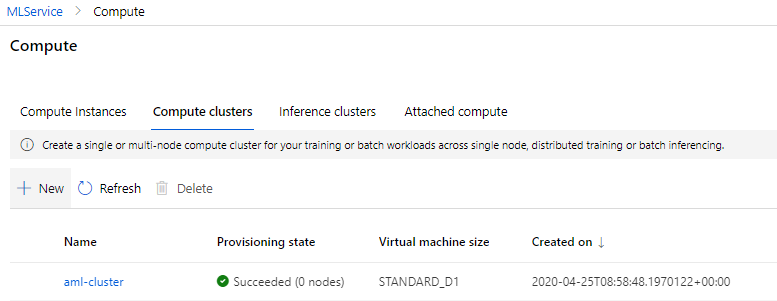

The code below provision the **Training Cluster  -> 'aml-cluster'** used for training purpose. 
Define size of the VM, max nodes and regestering the same with the workspace.

In [ ]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = 'aml-cluster'
try:
    trn_cluster = ComputeTarget(workspace=ws, name=cluster_name)
except ComputeTargetException:
    compute_config=AmlCompute.provisioning_configuration(vm_size='STANDARD_D1', max_nodes=4)
    trn_cluster=ComputeTarget.create(ws,cluster_name,compute_config)
trn_cluster.wait_for_completion(show_output=True)

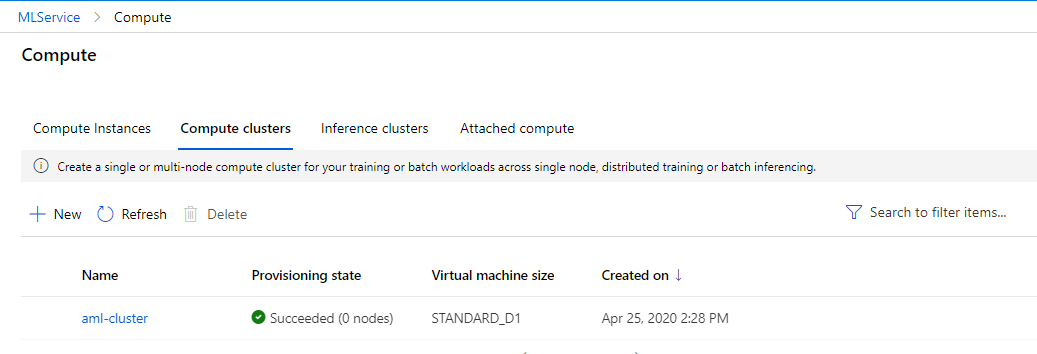

## Training Using Environment & Managed Compute
Below is the crux of the entire experiment  - using the environment and compute targets as defined above, run the experiment with the estimator.
> Note: The experiment will take quite a lot longer because a container image must be built with the conda environment, and then the cluster nodes must be started and the image deployed before the script can be run.

In [ ]:
from azureml.train.sklearn import SKLearn ## note - directly using SKLearn as estimator, hence avoid using conda_packages
from azureml.core import Experiment, Dataset, Environment
from azureml.widgets import RunDetails

# Get the previously registered Environmnt.
reg_env = Environment.get(ws,'iris_trn_environment')

# Get the previously registered tabular flower dataset
tab_dataset = ws.datasets.get('flower tab ds')

# Create an estimator, look into the 'compute_target' & 'environment_definition' additional parameters and their values
estimator = SKLearn(source_directory=tab_ds_experiment, ## pointing to the correct experiment folder for this context
                      entry_script='iris_simple_DTexperiment.py',
                      compute_target=cluster_name, ## Pass the value of cluster created as above
                      environment_definition = reg_env, ## Pass the value of registered  Environment as created already
                      use_docker=False,
                      inputs=[tab_dataset.as_named_input('flower_ds')] ## pass the 'tab_dataset' as input to the experiment
                      )

# Create an experiment
experiment_name = 'iris-compute-experiment'
experiment = Experiment(workspace = ws, name = experiment_name)

# Run the experiment based on the estimator
run = experiment.submit(config=estimator)

# Get Run Details
RunDetails(run).show()

# Wait to complete the experiment. In the Azure Portal we will find the experiment state as preparing --> finished.
run.wait_for_completion(show_output=True)

#### Cluster Provisioning
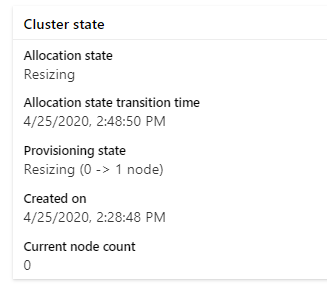

#### Experiment submitted and running on the cluster
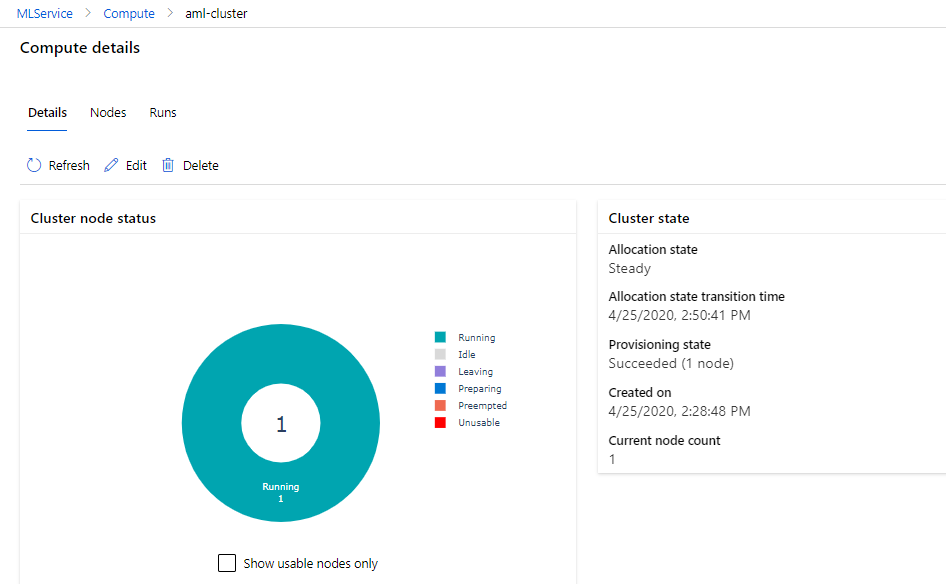

#### Provisioning of the Node
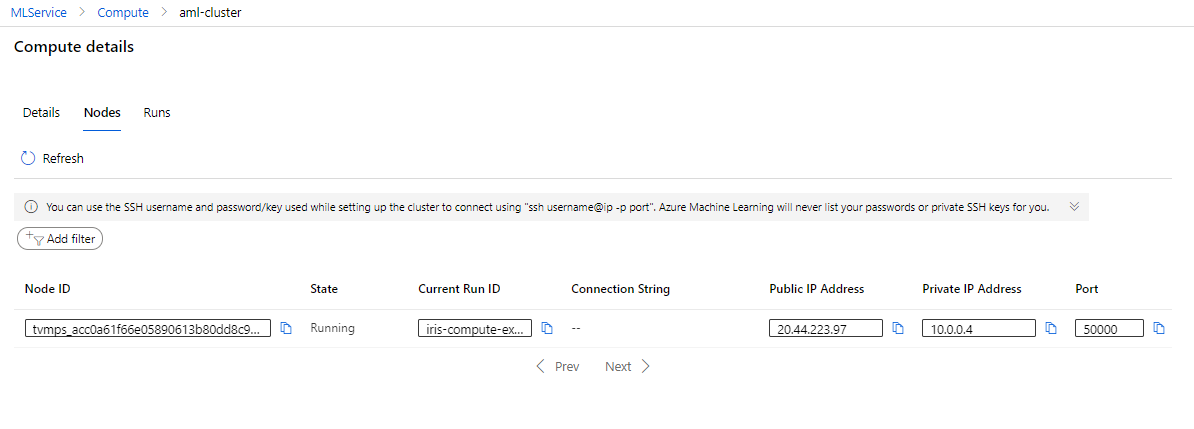

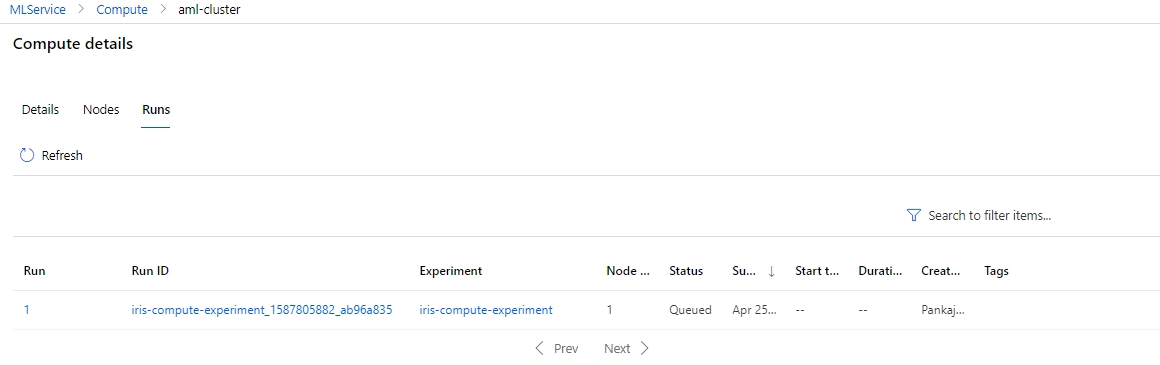

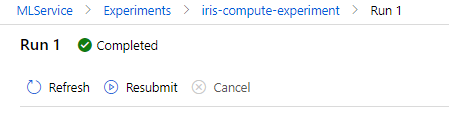

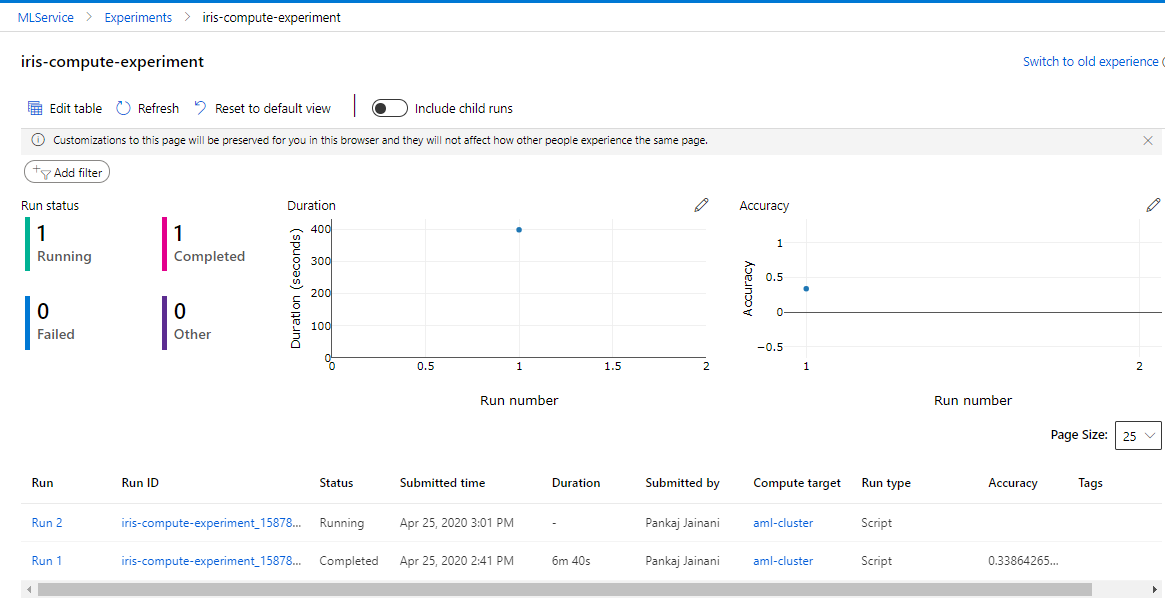

## What Next?
In the next notebook I will show to create E2E Machine Learning project pipeline which can later be utilized for the model deployment on Inference clusters. Stay Tuned...